### Evaluación del modelo en condiciones aproximadas a producción
(estimación de rentabilidad del sistema)

#### Importamos librerías necesarias

In [1]:
import sys
sys.path.append("../") # go to parent dir
sys.path.append("../../") # go to parent dir

In [2]:
import pickle
from modelos import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
df_2024 = pd.read_parquet("../clean/df_2024.parquet")
df_2024[(df_2024.dia == 7) & (df_2024.mes == 5)]

,anio,mes,dia,moonphase,hora,temp,dewPt,heat_index,rh,pressure,...,wdir_VAR,wdir_W,wdir_WNW,wdir_WSW,Vviento,AlturaOlas,PeriodoOlas,Temperatura,Lluvia,Nubosidad
1388,2024,5,7,0.0,7,50.0,46.0,50.0,87.0,30.080,...,0,0,0,0,8,0.6,8,7,0.0,58
1389,2024,5,7,0.0,8,51.0,46.0,51.0,84.5,30.080,...,0,0,0,0,9,0.6,8,9,0.0,100
1390,2024,5,7,0.0,9,53.0,47.0,53.0,82.0,30.110,...,0,0,0,0,8,0.6,8,10,0.0,100
1391,2024,5,7,0.0,10,54.0,47.0,54.0,79.5,30.110,...,1,0,0,0,7,0.6,8,11,0.0,100
1392,2024,5,7,0.0,11,55.0,48.0,55.0,77.0,30.125,...,1,0,0,0,5,0.5,8,12,0.0,100
1393,2024,5,7,0.0,13,58.0,50.0,58.0,74.5,30.140,...,0,1,0,1,3,0.5,8,14,0.0,98
1394,2024,5,7,0.0,14,60.0,50.0,60.0,70.0,30.140,...,0,0,0,1,5,0.5,8,14,0.0,77
1395,2024,5,7,0.0,15,58.0,47.0,58.0,67.0,30.155,...,0,0,0,0,7,0.5,8,14,0.0,43
1396,2024,5,7,0.0,16,57.0,48.0,57.0,72.0,30.170,...,0,0,0,0,7,0.5,8,13,0.0,63
1397,2024,5,7,0.0,17,55.0,48.0,55.0,77.0,30.170,...,0,0,0,0,6,0.5,8,12,0.0,89


Cargamos los datos de forecast

In [4]:
df_forecast = pd.read_csv('../clean/forecast_merged.csv')

In [5]:
df_forecast.columns

Index(['Vviento', 'PeriodoOlas', 'Nubosidad', 'Lluvia', 'antelacion', 'hora',
       'dia', 'anio', 'mes', 'temp', 'dewPt', 'heat_index', 'rh', 'pressure',
       'vis', 'wc', 'feels_like', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE',
       'wdir_N', 'wdir_NE', 'wdir_NNE', 'wdir_NNW', 'wdir_NW', 'wdir_S',
       'wdir_SE', 'wdir_SSE', 'wdir_SSW', 'wdir_SW', 'wdir_VAR', 'wdir_W',
       'wdir_WNW', 'wdir_WSW', 'moonphase', 'AlturaOlas'],
      dtype='object')

In [6]:
antelaciones = df_forecast['antelacion'] # guardamos para evaluar posteriormente

#### Separamos en explicativas y respuesta

In [7]:
X, y = df_forecast.drop(columns=['AlturaOlas', 'anio', 'mes', 'dia', 'hora']), df_forecast['AlturaOlas']

#### Cargamos el modelo definitivo

In [8]:
filename = '../modelos/modelo_definitivo/modelo_rf_def.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)

model

RandomForestRegressor(max_depth=28, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=201, random_state=777)

Obtenemos la escala de los datos de entrenamiento

In [9]:
filename = '../modelos/modelo_definitivo/scaler.pkl'

with open(filename, 'rb') as file:
    scaler = pickle.load(file)


scaler

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['moonphase', 'temp', 'dewPt', 'heat_index',
                                  'rh', 'pressure', 'vis', 'wc', 'feels_like',
                                  'uv_index', 'Vviento', 'PeriodoOlas',
                                  'Lluvia', 'Nubosidad'])])

In [10]:
len(y)

4428

In [11]:
filtro_observaciones_reales = ~y.isna()
filtro_observaciones_reales.sum()

1011

Para medir el éxito de las predicciones necesitamos esperar hasta que el suceso se haya dado y comparar. Es decir, para comprobar cómo de buena ha sido nuestra predicción de las olas a las 14h necesitamos que pasen las 14h, recoger la altura real y compararlo con nuestra predicción.

Es por eso que nuestra columna y (AlturaOlas) tiene muchos NaNs, pues se tratan de observaciones que son futuras al momento actual.

Para hacer el análisis únicamente podemos usar datos que ya han sido confirmados. En un futuro cuando las predicciones tengan un valor real con el cual compararse, obtendremos un mayor espacio de predicciones con el cual medir el rendimiento del modelo.

In [12]:
X_obs_reales = X[filtro_observaciones_reales]
y_obs_reales = y[filtro_observaciones_reales]
antelacion_obs_reales = antelaciones[filtro_observaciones_reales]

In [13]:
# predicciones = model.predict(X)
predicciones_obs_reales = model.predict(scaler.transform(X_obs_reales))

In [14]:
# calcular_metricas(y, predicciones)
calcular_metricas(y_obs_reales, predicciones_obs_reales)

{'TEST_MAX_ERROR': 0.6023284875710251,
 'TEST_ROOT_MEAN_SQ_ERROR': 0.16658823290958938,
 'TEST_MEDIAN_ABS_ERROR': 0.10911256791853846,
 'TEST_MEAN_ABS_ERROR': 0.13196276135100812}

Text(0.5, 0, 'TRUE (metros)')

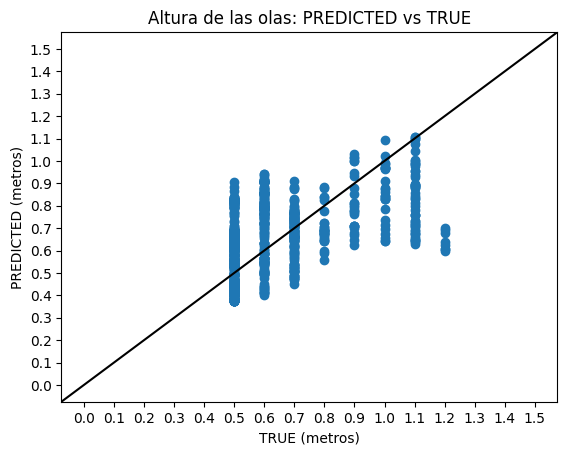

In [15]:
plt.scatter(y_obs_reales, predicciones_obs_reales)
plt.xticks([i/10 for i in range(0,16)])
plt.yticks([i/10 for i in range(0,16)])
plt.axline([0,0], [1.5, 1.5], color='0')
plt.title('Altura de las olas: PREDICTED vs TRUE')

plt.ylabel('PREDICTED (metros)')
plt.xlabel('TRUE (metros)')

#### Ahora pasaríamos a analizar el error en función de la antelación de la predicción

In [16]:
def rmse(y, predicciones):
    return np.sqrt(((y-predicciones)**2).sum())

In [17]:
rmse(y_obs_reales[antelacion_obs_reales == 25], predicciones_obs_reales[antelacion_obs_reales == 25])

0.738352618786684

In [18]:
antelaciones_ordenadas = np.sort(antelacion_obs_reales.unique())

antelaciones_ordenadas = antelaciones_ordenadas.astype(int)

In [19]:
df_evaluacion = pd.DataFrame(columns = ["antelacion","RMSE", "num_preds"])
# df_evaluacion.loc[len(df_evaluacion)] = [4, 'D']
df_evaluacion

,antelacion,RMSE,num_preds


In [20]:
import matplotlib.pyplot as plt

for i in antelaciones_ordenadas:
    df_evaluacion.loc[len(df_evaluacion)] = [i, rmse(y_obs_reales[antelacion_obs_reales == i], predicciones_obs_reales[antelacion_obs_reales == i]), len(antelacion_obs_reales == i)]

In [21]:
df_evaluacion.antelacion = df_evaluacion.antelacion.astype(int)

In [22]:
df_evaluacion.num_preds = df_evaluacion.num_preds.astype(int)

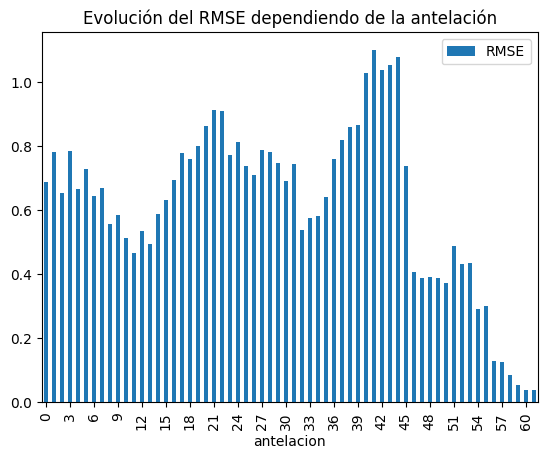

In [23]:
df_evaluacion.plot(kind = "bar", x = "antelacion", y = "RMSE", title = "Evolución del RMSE dependiendo de la antelación");
plt.xticks([i for i in range(0,df_evaluacion.antelacion.max() + 1, 3)]);

<Axes: ylabel='antelacion'>

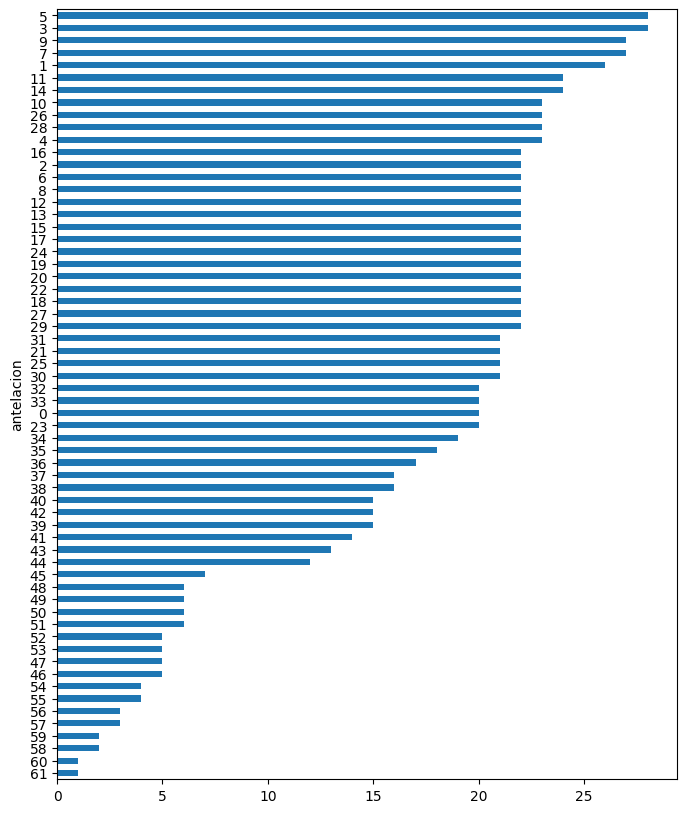

In [24]:
plt.figure(figsize=(8,10))
antelacion_obs_reales.sort_values().value_counts().sort_values().plot(kind="barh")

Nos quedamoscon 2, 6, 12, 18, 24 que son los que tienen el mismo número de filas

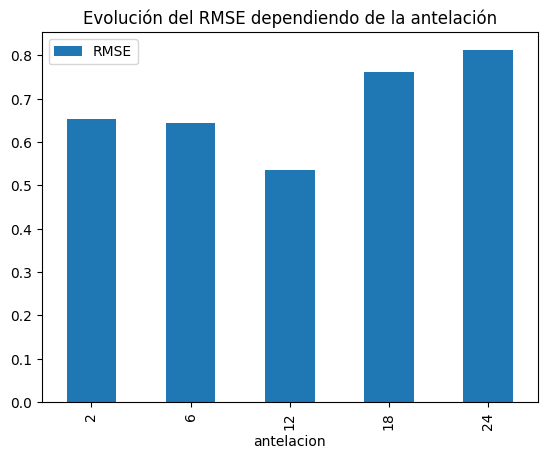

In [25]:
df_evaluacion[df_evaluacion.antelacion.isin(pd.Series([2,6, 12, 18, 24]))].plot(kind = "bar", x = "antelacion", y = "RMSE", title = "Evolución del RMSE dependiendo de la antelación");

Comparación del rendimiento usando datos reales vs predicciones
-

In [26]:
df_2024 = pd.read_parquet("../clean/df_2024.parquet")

df_forecast = pd.read_csv('../clean/forecast_merged.csv')

In [27]:
y = df_forecast['AlturaOlas']

In [28]:
filtro_observaciones_reales = ~y.isna() #Predicciones que ya tienen una confirmacion real
filtro_observaciones_reales.sum()

1011

Nos quedamos con las fechas únicas que tienen confirmación real

In [29]:
fechas = df_forecast[filtro_observaciones_reales][['anio', 'mes', 'dia', 'hora']].drop_duplicates()
fechas.shape

(118, 4)

Hacemos el inner join con esto para quedarnos solo con filas que estan en ambas tablas

In [30]:
#Seleccionamos únicamente los datos reales que coinciden con las predicciones. 
# Como los datos reales acaban un poco antes que las predicciones no hace falta acotar por encima
X_obs_reales = df_2024.merge(fechas, on=['anio', 'mes', 'dia', 'hora'])
X_obs_reales.shape

(68, 38)

In [31]:
#Construimos un df para predecir con los datos reales, y guardamos el valor real de la altura de la ola.
X_obs_reales_limpio = X_obs_reales.drop(columns=['anio', 'mes', 'dia', 'hora', 'Temperatura', 'wspd', 'AlturaOlas']) 
y_reales = X_obs_reales["AlturaOlas"]

In [32]:
X_obs_reales_limpio.columns

Index(['moonphase', 'temp', 'dewPt', 'heat_index', 'rh', 'pressure', 'vis',
       'wc', 'feels_like', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE',
       'wdir_N', 'wdir_NE', 'wdir_NNE', 'wdir_NNW', 'wdir_NW', 'wdir_S',
       'wdir_SE', 'wdir_SSE', 'wdir_SSW', 'wdir_SW', 'wdir_VAR', 'wdir_W',
       'wdir_WNW', 'wdir_WSW', 'Vviento', 'PeriodoOlas', 'Lluvia',
       'Nubosidad'],
      dtype='object')

In [33]:
# predecimos con los datos reales escalando los datos
predicciones_usando_datos_reales = model.predict(scaler.transform(X_obs_reales_limpio))

In [34]:
calcular_metricas(y_reales, predicciones_usando_datos_reales)

{'TEST_MAX_ERROR': 0.4768470024999871,
 'TEST_ROOT_MEAN_SQ_ERROR': 0.19601692888137937,
 'TEST_MEDIAN_ABS_ERROR': 0.11210633686379906,
 'TEST_MEAN_ABS_ERROR': 0.15201346613399613}

In [35]:
df_forecast_fechas_iguales = df_forecast.merge(X_obs_reales[['anio', 'mes', 'dia', 'hora']], on=['anio', 'mes', 'dia', 'hora'])
# vemos el numero de filas para ver si coincide de fechas (descartamos duplicados de antelacion)
df_forecast_fechas_iguales.drop_duplicates(['anio', 'mes', 'dia', 'hora']).shape

(68, 37)

In [36]:
df_forecast_fechas_iguales

,Vviento,PeriodoOlas,Nubosidad,Lluvia,antelacion,hora,dia,anio,mes,temp,...,wdir_SE,wdir_SSE,wdir_SSW,wdir_SW,wdir_VAR,wdir_W,wdir_WNW,wdir_WSW,moonphase,AlturaOlas
0,7,4,100,0.6,0,16,2,2024,5,49,...,0,0,0,0,0,1,0,0,0.81,0.8
1,6,4,100,0.0,1,17,2,2024,5,49,...,0,0,0,0,0,1,0,0,0.81,0.8
2,5,5,100,0.0,2,18,2,2024,5,48,...,0,0,0,0,0,0,1,0,0.81,0.8
3,5,5,100,0.1,3,19,2,2024,5,50,...,0,0,0,0,0,0,1,0,0.81,0.8
4,6,5,100,0.0,0,18,2,2024,5,48,...,0,0,0,0,0,0,1,0,0.81,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,4,8,28,NaN,12,11,7,2024,5,57,...,0,0,0,0,0,0,0,0,0.00,0.5
498,4,8,31,NaN,14,13,7,2024,5,60,...,0,0,0,0,0,0,0,1,0.00,0.5
499,7,8,36,NaN,16,15,7,2024,5,61,...,0,0,1,0,0,0,0,0,0.00,0.5
500,7,8,48,NaN,18,17,7,2024,5,60,...,0,0,1,0,0,0,0,0,0.00,0.5


In [37]:
y_forecast = df_forecast_fechas_iguales[df_forecast_fechas_iguales.antelacion <= 48]["AlturaOlas"]
df_forecast_fechas_iguales = df_forecast_fechas_iguales.drop(columns=['AlturaOlas', 'anio', 'mes', 'dia', 'hora'])
df_forecast_fechas_iguales_antelaciones_menores_48 = df_forecast_fechas_iguales[df_forecast_fechas_iguales.antelacion <= 48]

In [38]:
predicciones_forecast = model.predict(scaler.transform(df_forecast_fechas_iguales_antelaciones_menores_48))

In [39]:
calcular_metricas(y_forecast, predicciones_forecast)

{'TEST_MAX_ERROR': 0.5742213977288604,
 'TEST_ROOT_MEAN_SQ_ERROR': 0.15671852379490173,
 'TEST_MEDIAN_ABS_ERROR': 0.09663322926382639,
 'TEST_MEAN_ABS_ERROR': 0.12290703631349997}

In [40]:
#Volvemos a copiar la celda
calcular_metricas(y_reales, predicciones_usando_datos_reales)

{'TEST_MAX_ERROR': 0.4768470024999871,
 'TEST_ROOT_MEAN_SQ_ERROR': 0.19601692888137937,
 'TEST_MEDIAN_ABS_ERROR': 0.11210633686379906,
 'TEST_MEAN_ABS_ERROR': 0.15201346613399613}

In [41]:
df_results = pd.DataFrame([calcular_metricas(y_reales, predicciones_usando_datos_reales), calcular_metricas(y_forecast, predicciones_forecast)])
df_results['DATOS'] = ['OBS', 'FORECAST']
df_results

,TEST_MAX_ERROR,TEST_ROOT_MEAN_SQ_ERROR,TEST_MEDIAN_ABS_ERROR,TEST_MEAN_ABS_ERROR,DATOS
0,0.476847,0.196017,0.112106,0.152013,OBS
1,0.574221,0.156719,0.096633,0.122907,FORECAST


Comprobamos que el modelo tiene mejores métricas si predecimos sobre datos reales en vez de predicciones, aunque podemos ver que el error añadido de las predicciones explicativas no es muy elevado, únicamente afecta en décimas a una métrica. La métrica más afectada es TEST_MAX_ERROR, puesto que el resto de métricas dan mejores resultados incluso usando predicciones sobre las variables explicativas.

NOTA: Para comparar estos datos hemos usado las mismas observaciones temporales, pero en un caso con datos de predicciones y en el otro caso con datos reales.

Aun así es complicado sacar conclusiones porque las olas de los días donde hemos hecho predicciones no han sido muy elevadas, mientras que nuestro modelo era bueno para predecir olas de gran altura.

Aunque no es una prueba muy importante vamos a intentar calcular las métricas de nuestro modelo para datos de test reales de 2024, siguiendo la hipótesis de que trabajar con predicciones en las variables explicativas afecta ligeramente al rendimiento del modelo (como hemos dicho no podemos comprobar si trabajar con predicciones en las variables explicativas afecta al modelo para grandes olas porque todavía no se han dado en la vida real)


In [42]:
df_2024 = pd.read_parquet("../clean/df_2024.parquet")
df_2024

,anio,mes,dia,moonphase,hora,temp,dewPt,heat_index,rh,pressure,...,wdir_VAR,wdir_W,wdir_WNW,wdir_WSW,Vviento,AlturaOlas,PeriodoOlas,Temperatura,Lluvia,Nubosidad
0,2024,1,1,0.69,8,37.0,36.0,37.0,93.0,29.400,...,0,0,0,0,10,1.6,9,8,0.1,100
1,2024,1,1,0.69,9,40.0,38.0,40.0,93.0,29.370,...,1,0,0,0,10,1.6,9,8,0.1,100
2,2024,1,1,0.69,10,46.0,43.0,46.0,87.0,29.360,...,0,0,0,0,10,1.5,9,8,0.7,100
3,2024,1,1,0.69,11,46.0,44.0,46.0,90.0,29.320,...,0,0,0,0,15,1.6,9,9,0.7,100
4,2024,1,1,0.69,12,47.0,47.0,47.0,100.0,29.245,...,0,0,0,0,17,1.7,9,9,0.5,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,2024,5,7,0.00,15,58.0,47.0,58.0,67.0,30.155,...,0,0,0,0,7,0.5,8,14,0.0,43
1396,2024,5,7,0.00,16,57.0,48.0,57.0,72.0,30.170,...,0,0,0,0,7,0.5,8,13,0.0,63
1397,2024,5,7,0.00,17,55.0,48.0,55.0,77.0,30.170,...,0,0,0,0,6,0.5,8,12,0.0,89
1398,2024,5,7,0.00,18,54.0,50.0,54.0,88.0,30.170,...,0,0,0,0,6,0.5,8,12,0.0,95


In [43]:
y_2024 = df_2024["AlturaOlas"]

In [44]:
df_2024_clean = df_2024.drop(columns = ['anio', 'mes', 'dia', 'hora', 'Temperatura', 'wspd', 'AlturaOlas'])

In [45]:
predicciones_modelo_sobre_2024 = model.predict(scaler.transform(df_2024_clean))

In [46]:
calcular_metricas(y_2024, predicciones_modelo_sobre_2024)

{'TEST_MAX_ERROR': 2.205047794935857,
 'TEST_ROOT_MEAN_SQ_ERROR': 0.4061417345073361,
 'TEST_MEDIAN_ABS_ERROR': 0.20639232791888634,
 'TEST_MEAN_ABS_ERROR': 0.2891466296336764}

Si recuperamos la métrica que teía nuestro modelo en test mirando en MLFlow comprobamos que sus métricas eran las siguientes:

- TEST_MAX_ERROR = 2.614159377107139
- TEST_ROOT_MEAN_SQ_ERROR = 0.3888818027489544
- TEST_MEDIAN_ABS_ERROR = 0.18884458660303644
- TEST_MEAN_ABS_ERROR = 0.27304772724375703

Podemos ver que las métricas son muy similares entre los datos de test.

Podemos llegar a una conclusión basada en la hipótesis anterior de que nuestro modelo generaliza bien a nuevos datos, aunque como ya hemos dicho, hace falta esperar a que en el futuro se den olas de diferentes alturas para saber en un mayor espacio muestral si nuestro modelo predice bien trabajando con predicciones.

HIPÓTESIS ANTERIOR:

trabajar con predicciones en las variables explicativas afecta ligeramente al rendimiento del modelo